# R関数の共起性グラフ

2017年10月16日


### 概要
RのBase関数約500個で同時に使われる組合せを視覚化。 <br>
同時に使われるデータとしてStackOverFlowのRの人気ページのトップ500を借用。 <br>



In [ ]:
# web scraping
# satoru tokuda
# 2017 Oct 13

#===========
# Goal (1)
# Draw a network graph of R functions (package base)
# to see the relationship of the reserved words

# Goal (2)
# categorize R snippets, so that
# (a) DS members can learn how R snippets are clustered,
# (b) DS members can categorize new R snippets

#===========
# Definition
# "a listing page" is a web page that lists a series of web pages.
# "an asking page" is a web page where someone asks a question.

In [1]:
# ---------
# Part 1
# Install and load library
  if(!("rvest"    %in% installed.packages()[,"Package"])) install.packages("rvest")
  if(!("reshape2" %in% installed.packages()[,"Package"])) install.packages("reshape2")
  if(!("igraph"   %in% installed.packages()[,"Package"])) install.packages("igraph")
  if(!("dplyr"    %in% installed.packages()[,"Package"])) install.packages("dplyr")
  if(0){  detach("package:XML", unload=TRUE) }
  library(rvest)
  library(reshape2)
  library(MASS)
  library(igraph)
  library(dplyr)

Warning message:
"package 'rvest' was built under R version 3.3.3"Loading required package: xml2
Warning message:
"package 'xml2' was built under R version 3.3.3"Warning message:
"package 'reshape2' was built under R version 3.3.3"Warning message:
"package 'igraph' was built under R version 3.3.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'dplyr' was built under R version 3.3.3"Warning message:
"Installed Rcpp (0.12.8) different from Rcpp used to build dplyr (0.12.11).
Please reinstall dplyr to avoid random crashes or undefined behavior."
Attaching package: 'dplyr'

The following objects are masked from 'package:igraph':

    as_data_frame, groups, union

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'p

In [2]:
# ---------
# Part 2
# get R reserved words
  reservedWords = as.character(lsf.str("package:base")) # get all function names
  length(reservedWords) # [1] 1207 words
  reservedWords = reservedWords[ grepl(pattern = '[^[:alnum:]]', reservedWords) ==FALSE] # limit to alphabet only
  # remove some words (either ambiguous with English or too common)
  reservedWords = reservedWords[!reservedWords %in% c("c", "I", "as", "by", "is", "var", "if", "for",
                                                      "with", "function", "return", "library",
                                                      "require")]
  reservedWords = unique(reservedWords) # remove duplicated if any
  length(reservedWords) # [1] 550 words


[1] 1207

[1] 548

In [5]:

# ---------
# Part 3
# Download URL Listing page HTML from StackOverFlow site 
  charListingUrl = vector(mode = "character", length = 0)
  lsListingHtml = list()
  maxFile = 10 # the max number of the listing pages to download. Each listing page contains 50 URLs.
  charListingUrl[1] = "https://stackoverflow.com/questions/tagged/r?sort=frequent&pageSize=50" # Page 1
  charListingUrl[2:maxFile] = paste0("https://stackoverflow.com/questions/tagged/r?page=", seq(2,maxFile), "&sort=frequent&pagesize=50") # Page 2
  
  # create dir if not exists
  dirSub1 = "html"
  ifelse(dir.exists(dirSub1), 1, dir.create(dirSub1) ) 
  dirSub2 = "html/htmlUrlList"
  ifelse(dir.exists(dirSub2), 1, dir.create(dirSub2) ) 

  for(fCt in 1:maxFile){
    charListingUrlNoPunct = gsub(pattern = "[:/?.&=]", replacement = "_", charListingUrl[fCt])
    charListingFilePathNoPunct =  paste0("html/htmlUrlList/", charListingUrlNoPunct, ".html") 
    if(file.exists(charListingFilePathNoPunct)){ # download HTML if not exists in local
      lsListingHtml[[fCt]] = read_html(charListingFilePathNoPunct) # Load HTML info from Local folder
    }else{
      lsListingHtml[[fCt]] = read_html(charListingUrl[fCt]) #  Load HTML from internet
      charUrlPageList = as(lsListingHtml[[fCt]], "character") # convert into char before storing
      write(x = charUrlPageList, file = charListingFilePathNoPunct )#  store HTML as character
      Sys.sleep(0.01); print(paste0("Downloading HTML file ", fCt, " from the net out of ", maxFile, " done") )
    }
  }


[1] TRUE

[1] TRUE

[1] "Downloading HTML file 1 from the net out of 10 done"
[1] "Downloading HTML file 2 from the net out of 10 done"
[1] "Downloading HTML file 3 from the net out of 10 done"
[1] "Downloading HTML file 4 from the net out of 10 done"
[1] "Downloading HTML file 5 from the net out of 10 done"
[1] "Downloading HTML file 6 from the net out of 10 done"
[1] "Downloading HTML file 7 from the net out of 10 done"
[1] "Downloading HTML file 8 from the net out of 10 done"
[1] "Downloading HTML file 9 from the net out of 10 done"
[1] "Downloading HTML file 10 from the net out of 10 done"


In [15]:
# ---------
# Part 4
# Get 50 URLs from each listing page
  urlStack = NULL
  fun_strsplit_return_first = function(askingPageUrl){  # small function to return the first element
    outSplit = strsplit(x = as.character(askingPageUrl), split = "\" class=") # separate by the pattern
    return(outSplit[[1]][1]) # then return only the first element after separation
  }  
  
  for(listingCt in 1:maxFile){
    askingPageUrl = html_nodes(lsListingHtml[[listingCt]], "h3") # find "h3" in the HTML script
    Sys.sleep(0.01); print(paste("", length(askingPageUrl), " Asking pages found in this Listing Page.") )
    askingPageUrl = askingPageUrl[grepl(pattern = '<h3><a href="/questions/', askingPageUrl) == TRUE] # limit to data that contains "questions"
    askingPageUrl = lapply(X = askingPageUrl, FUN = fun_strsplit_return_first)
    askingPageUrl = unlist(askingPageUrl)
    # replace with www
    askingPageUrl = gsub(pattern = "<h3><a href=\"/", replacement = "https://stackoverflow.com/", x = askingPageUrl)
    askingPageUrl = gsub(pattern = "\\?</a></h3>", replacement = "", x = askingPageUrl)
    urlStack = c(urlStack, askingPageUrl)
  }

  # create dir if not exists
  dirSub1 = "output"
  ifelse(dir.exists(dirSub1), 1, dir.create(dirSub1) ) 
  write.csv(urlStack, paste0(dirSub1, "/URL_Top500_R_pages_in_stackoverflow.csv"))



[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."
[1] " 53  Asking pages found in this Listing Page."


[1] TRUE

In [8]:
# Note. Running this section took me 21 minutes. Be patient.

# ---------
# Part 5
# download and load each Asking page 
    
  # create dir if not exists
  dirSub2 = "html/htmlAskingPage"
  ifelse(dir.exists(dirSub2), 1, dir.create(dirSub2) ) 
  
  lenSnipet = length(urlStack)
  lsSnipetHtml = list()
  askPageCt = 1
  for(askPageCt in 1:lenSnipet){
    askingUrlNoPunct = gsub(pattern = "[:/?.&=]", replacement = "_", urlStack[askPageCt])
    askingFilePathNoPunct = paste0("html/htmlAskingPage/", askingUrlNoPunct, ".html")
    if(file.exists(askingFilePathNoPunct)){# Use local html file if exists
      lsSnipetHtml[[askPageCt]] = read_html(askingFilePathNoPunct) # Load asking page from local
    }else{
      lsSnipetHtml[[askPageCt]] = read_html(urlStack[askPageCt]) # load asking page from internet
      charUrlPageList = as(lsSnipetHtml[[askPageCt]], "character")
      write(x = charUrlPageList, file = askingFilePathNoPunct )
    }
    if(askPageCt%%50 == 0 | askPageCt == 1){
      Sys.sleep(0.01); print(urlStack[askPageCt])
      Sys.sleep(0.01); print(paste0("Downloading HTML file ", askPageCt, " from the net out of ", lenSnipet, " done") )
    }
  }

[1] TRUE

[1] "https://stackoverflow.com/questions/5963269/how-to-make-a-great-r-reproducible-example"
[1] "Downloading HTML file 1 from the net out of 500 done"
[1] "https://stackoverflow.com/questions/27721008/how-do-i-deal-with-special-characters-like-in-my-regex"
[1] "Downloading HTML file 50 from the net out of 500 done"
[1] "https://stackoverflow.com/questions/26291988/how-to-create-a-lag-variable-within-each-group"
[1] "Downloading HTML file 100 from the net out of 500 done"
[1] "https://stackoverflow.com/questions/6919025/how-to-assign-colors-to-categorical-variables-in-ggplot2-that-have-stable-mappin"
[1] "Downloading HTML file 150 from the net out of 500 done"
[1] "https://stackoverflow.com/questions/22756372/collapse-text-by-group-in-data-frame"
[1] "Downloading HTML file 200 from the net out of 500 done"
[1] "https://stackoverflow.com/questions/4951442/formula-with-dynamic-number-of-variables"
[1] "Downloading HTML file 250 from the net out of 500 done"
[1] "https://stackoverflow.com

In [9]:

# ---------
# Part 6
# find snippets in each of the 500 pages
  lsSnippet = lapply(X = lsSnipetHtml, FUN = function(x) html_nodes(x, "pre") %>% html_nodes("code")  )
  vecSnippet = unlist(lapply(X = lsSnippet, FUN = as.character))
  length(vecSnippet) # [1] 5346 snippets in 500 pages
  

[1] 5289

In [10]:

# ---------
# Part 7
  # limit to valid snippets
  iRem = which(  substr(vecSnippet, start = 1, stop = 6) != "<code>" )
  iRem # none to remove. No action taken.
  

integer(0)

In [11]:
 
# ---------
# Part 8
  # remove suffix of the snippets
  vecSnippet = gsub(pattern = "<code>|</code>|\n", replacement = " ", x = vecSnippet) # remove <code> and </code>
  vecSnippet = gsub(pattern = "[^[:alnum:].]", replacement = " ", vecSnippet)


In [12]:

# ---------
# Part 9
  # string split
  # find R reserved functions
  lsSplitSnippet = strsplit(vecSnippet, " ")
  
  # function to find the exact reserved words in the snipet
  fun_find_reserved_in_str = function(stringFromSnipet, reservedWords){
    iHitReserved = which(reservedWords %in% stringFromSnipet)
    return(reservedWords[iHitReserved])
  }
  lsfoundFunc = lapply(X = lsSplitSnippet, FUN = fun_find_reserved_in_str, reservedWords)
  # remove elements with no words
  flagRem  = unlist(lapply(X = lsfoundFunc, FUN = function(x) identical(x, character(0)) ))
  lsfoundFunc = lsfoundFunc[!flagRem]
  

In [13]:

# ---------
# Part 10
  # permute and dedupe
  # function permute the combination of words. Dedupe the order differences.
  fun_permute_dedupe = function(vecFoundFunc){
    dfGrid = expand.grid(vecFoundFunc, vecFoundFunc)
    dfPerm = dfGrid[which(as.character(dfGrid$Var1) < as.character(dfGrid$Var2) ), ] # limit to younger alphabet < older alphabet
    return(dfPerm)
  }
  dfPerm = lapply(X = lsfoundFunc, FUN = fun_permute_dedupe)
  # stack all the perms together
  bindPerm = do.call(what = rbind, args = dfPerm)
  # count perm
  dfCtPerm = as.data.frame(group_by(bindPerm, Var1, Var2)  %>% summarize(freq = n()) )
  

[1] 86

Var1,Freq
abs,14
addTaskCallback,1
alist,3
all,131
any,40
anyDuplicated,1


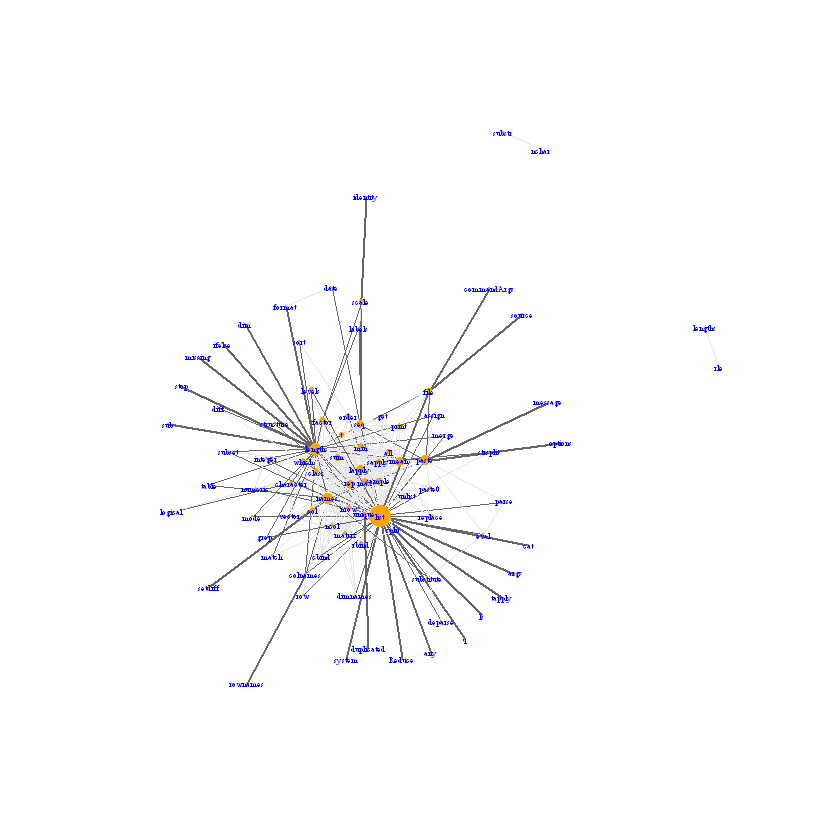

In [14]:

  
# ---------
# Part 11
  # network graph
  cutPointNode = 11
  dfCtOver2 = dfCtPerm[ dfCtPerm$freq >= cutPointNode, ] # limit to freq over 2
  length(unique(c(dfCtOver2$Var1, dfCtOver2$Var2)))
  grCtOver2 <- graph.data.frame(dfCtOver2, directed = FALSE)
  
  # calculate the size of the edge
  dfFuncCount = as.data.frame.table(table(unlist(lsfoundFunc)))
  head(dfFuncCount)
  matchNum = match(V(grCtOver2)$name, dfFuncCount$Var1 )
  dfFuncCountCut = dfFuncCount[ matchNum, ]

  V(grCtOver2)$size      <- ( dfFuncCountCut$Freq / max(dfFuncCountCut$Freq)) * 8       ## circle size proportional to text size
  # for(seedCt in 31:40){ # 19 31 35 36
  # set.seed(seedCt)    
  set.seed(35)    
  plot(grCtOver2, 
       vertex.label = V(grCtOver2)$name, 
       vertex.color="orange", # shape color
       vertex.frame.color="orange", # border color
       vertex.label.cex = 0.4,
       vertex.label.color= "blue",
       edge.width = 0.02 * edge.betweenness(grCtOver2),
       edge.color = ifelse(
         edge.betweenness(grCtOver2) > quantile(edge.betweenness(grCtOver2))[4], 
         "gray40","gray90") # use light color for marginal connections. Use dark color for the important.
  )  
  
  